100
hid_orderings [1, 2, 2, 1, 2, 2, 1, 0, 1, 0, 2, 1, 2, 0, 0, 0] size 16
expanded_input_ordering [0, 0, 0, 0, 0, 0, 0, 0, 1] size 9
expanded_output_ordering [2, 2] size 2
hid_orderings [1, 2, 1, 3, 2, 0, 0, 2, 0, 3, 0, 3, 0, 4, 2, 6, 1, 3, 5, 2, 2, 4, 6, 6, 2, 5, 4, 2, 1, 0, 6, 0] size 32
expanded_input_ordering [0, 0, 0, 0, 0, 0, 0, 0, 1, 2] size 10
expanded_output_ordering [4, 6, 4, 6] size 4
hid_orderings [7, 8, 2, 9, 13, 11, 5, 1, 14, 7, 9, 12, 5, 0, 2, 10, 5, 13, 11, 14, 10, 4, 11, 0, 7, 13, 7, 2, 7, 8, 5, 13, 5, 4, 7, 3, 4, 5, 14, 1, 2, 2, 14, 13, 2, 8, 1, 4, 5, 8, 13, 12, 8, 11, 7, 10, 11, 3, 12, 8, 7, 5, 3, 7] size 64
expanded_input_ordering [0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3] size 11
expanded_output_ordering [7, 11, 8, 7, 11, 8] size 6
hid_orderings [7, 39, 56, 49, 38, 31, 43, 7, 3, 54, 22, 42, 26, 22, 48, 21, 47, 51, 11, 61, 3, 26, 31, 52, 11, 35, 23, 58, 7, 16, 51, 20, 59, 3, 24, 6, 36, 60, 20, 40, 16, 27, 36, 15, 43, 31, 57, 17, 60, 11, 1, 41, 46, 30, 2, 62, 8, 54, 56, 13, 

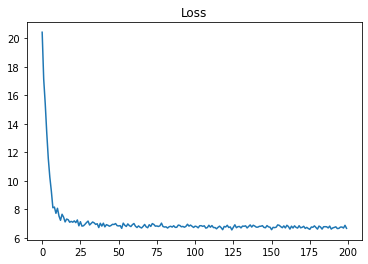

In [1]:
import numpy as np
import random
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import pyro
import pyro.contrib.examples.polyphonic_data_loader as poly
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from matplotlib import pyplot as plt
from made import MADE
from full_made import FullMade
from pyro.infer.autoguide import AutoDiagonalNormal, AutoNormal, AutoMultivariateNormal

random.seed(123)
torch.manual_seed(123)

# NN used for p(x | y)
class simpleNN(nn.Module):
    def __init__(self, input_size=1, hidden=32, out_size=1, t="normal", out_non_linear=None):
        super().__init__()
        self.t = t
        self.out_non_linear = out_non_linear
        self.hiddeen_layer = nn.Linear(input_size, hidden)
        if t == "normal":
            self.loc_layer = nn.Linear(hidden, out_size)
            self.std_layer = nn.Linear(hidden, out_size)
            self.softplus = nn.Softplus()
        elif t == "bern":
            self.prob_layer = nn.Linear(hidden, out_size)
        elif t == "mlp":
            self.out_layer = nn.Linear(hidden, out_size)
        
    def forward(self, x_list):
        for i in range(len(x_list)):
            if x_list[i].dim() == 0:
                x_list[i] = torch.unsqueeze(x_list[i], dim=0)
        input_x = torch.cat(x_list)
        hid = F.relu(self.hiddeen_layer(input_x))
        # return loc, std
        if self.t == "normal":
            return self.loc_layer(hid), self.softplus(self.std_layer(hid))
        elif self.t == "bern":
            return torch.sigmoid(self.prob_layer(hid))
        else:
            if self.out_non_linear == "tanh":
                return torch.tanh(self.out_layer(hid))
            else:
                return self.out_layer(hid)

class Experiment(nn.Module):
    def __init__(self):
        super().__init__()

        # guide full_made
        self.hidden_size_full_made = 8
        input_dim_dict = {
            "h" : self.hidden_size_full_made,
            "r" : 1
        }
        var_dim_dict = {
            "x1" : 1,
            "x2" : 1,
            "x3" : 1,
            "x4" : 1,
            "x5" : 1,
            "x6" : 1,
            "x7" : 1,
            "x8" : 1,
            "y1" : 1,
            "y2" : 1,
            "y3" : 1,
            "y4" : 1,
            "z1" : 1,
            "z2" : 1
        }
        dependency_dict = {
            "z2" : ["h", "r"],
            "z1" : ["h", "r", "z2"],
            "y4" : ["h", "z2"],
            "y3" : ["h", "z2", "y4"],
            "y2" : ["h", "z1"],
            "y1" : ["h", "z1", "y2"],
            "x8" : ["h", "y4"],
            "x7" : ["h", "y4", "x8"],
            "x6" : ["h", "y3"],
            "x5" : ["h", "y3", "x6"],
            "x4" : ["h", "y2"],
            "x3" : ["h", "y2", "x4"],
            "x2" : ["h", "y1"],
            "x1" : ["h", "y1", "x2"]
        }
        hidden_sizes = None # not used so far
        self.full_made = FullMade(input_dim_dict, hidden_sizes, dependency_dict, var_dim_dict)
        self.h0_full_made = nn.Parameter(torch.zeros(self.hidden_size_full_made))
        self.hid_net_full_made = simpleNN(self.hidden_size_full_made + 8 + 4 + 2, out_size = self.hidden_size_full_made, t = "mlp")
        
    def model(self, n, obs):
        def tree_model(i, mu):
            x1 = pyro.sample(f"x1{i}", dist.Normal(mu, 1.0))
            x2 = pyro.sample(f"x2{i}", dist.Normal(mu, 1.0))
            x3 = pyro.sample(f"x3{i}", dist.Normal(mu, 1.0))
            x4 = pyro.sample(f"x4{i}", dist.Normal(mu, 1.0))
            x5 = pyro.sample(f"x5{i}", dist.Normal(mu, 1.0))
            x6 = pyro.sample(f"x6{i}", dist.Normal(mu, 1.0))
            x7 = pyro.sample(f"x7{i}", dist.Normal(mu, 1.0))
            x8 = pyro.sample(f"x8{i}", dist.Normal(mu, 1.0))
            y1 = pyro.sample(f"y1{i}", dist.Normal(x1+x2, 1.0))
            y2 = pyro.sample(f"y2{i}", dist.Normal(x3+x4, 1.0))
            y3 = pyro.sample(f"y3{i}", dist.Normal(x5+x6, 1.0))
            y4 = pyro.sample(f"y4{i}", dist.Normal(x7+x8, 1.0))
            z1 = pyro.sample(f"z1{i}", dist.Normal(y1+y2, 1.0))
            z2 = pyro.sample(f"z2{i}", dist.Normal(y3+y4, 1.0))
            return z1 + z2  
            
        pyro.module("model", self)
        mu = 0
        for i in range(n):
            mu = tree_model(i, mu)
        
        pyro.sample("obs", dist.Normal(mu, 1.0), obs=obs)
    
    # reverse order of guide 6
    def guide_full_made(self, n, obs):
        def tree_guide(i, hid, last=False):
            # has to assume all interations are identical
            input_made = {
                "h" : hid,
                "r" : obs
            }
            if not last: 
                input_made["r"] = torch.tensor([0.])
            output_dict = self.full_made(input_made, i)
            input_hid = [hid]
            input_hid.extend(output_dict.values())
            
            # feed all outputs to update hid
            hid = self.hid_net_full_made(input_hid)

            return hid
            
        pyro.module("model", self)
        hid = self.h0_full_made
        for i in range(n-1, -1, -1):
            hid = tree_guide(i, hid, i==n-1)

def generate_data():
    
    n_min = 2
    n_max = 4
    n = random.randint(n_min, n_max)
    mu = 0
    x_len = 8
    for i in range(n):
        x_noise = torch.randn(x_len) / 4
        x_mean = torch.zeros(x_len) + mu
        xs = torch.normal(x_mean, 1) + x_noise
        ys = []
        j = 0
        while j < len(xs):
            y = dist.Normal(xs[j] + xs[j+1], 2).sample()
            ys.append(y)
            j +=2
        
        zs = []
        j = 0
        while j < len(ys):
            z = dist.Normal(ys[j] + ys[j+1], 1.5).sample()
            zs.append(z)
            j +=2
        
        
        mu = dist.Normal(zs[0] + zs[1], 1).sample() / 10
        
    return n, mu
    
data = []
num_data = 100
for _ in range(num_data):
    data.append(generate_data())

print(len(data))
experiment = Experiment()
adam_params = {"lr": 0.001, "betas": (0.95, 0.999)}
optimizer = Adam(adam_params)
guide = experiment.guide_full_made # guide_1

svi = SVI(experiment.model, guide, optimizer, loss=Trace_ELBO())

n_steps = 200
log_interval = 10
# do gradient steps
loss = 0
loss_track = []
for step in range(1, n_steps + 1):
    imme_loss = 0
    start = time.time()
    for n, obs in data:
        imme_loss += svi.step(n, obs.unsqueeze(0)) / num_data
        
    loss_track.append(imme_loss)
    loss += imme_loss / log_interval
    
    if step % log_interval == 0:
        print("[Step {}/{}] Immediate Loss: {:.5f} Accumlated Loss: {:.5f} Duration: {:.3f}".format(step, n_steps, imme_loss, loss, time.time() - start))
        loss = 0
    
plt.plot(loss_track)
plt.title("Loss")
plt.show()
    

In [ ]:
# full made
hidden_size = (|all_level_sets| + 1) * 4 
[Step 10/200] Immediate Loss: 7.73021 Accumlated Loss: 12.15332 Duration: 2.633
[Step 20/200] Immediate Loss: 7.16565 Accumlated Loss: 7.40011 Duration: 2.587
[Step 30/200] Immediate Loss: 7.08254 Accumlated Loss: 7.03757 Duration: 2.596
[Step 40/200] Immediate Loss: 6.83297 Accumlated Loss: 6.98378 Duration: 2.672
[Step 50/200] Immediate Loss: 6.86551 Accumlated Loss: 6.91275 Duration: 2.600
[Step 60/200] Immediate Loss: 6.93487 Accumlated Loss: 6.87233 Duration: 2.598
[Step 70/200] Immediate Loss: 6.71809 Accumlated Loss: 6.81451 Duration: 2.657
[Step 80/200] Immediate Loss: 6.80281 Accumlated Loss: 6.88790 Duration: 2.612
[Step 90/200] Immediate Loss: 6.90435 Accumlated Loss: 6.78826 Duration: 2.664
[Step 100/200] Immediate Loss: 6.73903 Accumlated Loss: 6.83094 Duration: 2.606
[Step 110/200] Immediate Loss: 6.89314 Accumlated Loss: 6.80484 Duration: 2.614
[Step 120/200] Immediate Loss: 6.80861 Accumlated Loss: 6.74317 Duration: 2.604
[Step 130/200] Immediate Loss: 6.80884 Accumlated Loss: 6.77493 Duration: 2.629
[Step 140/200] Immediate Loss: 6.83799 Accumlated Loss: 6.81526 Duration: 2.629
[Step 150/200] Immediate Loss: 6.75561 Accumlated Loss: 6.78899 Duration: 2.585
[Step 160/200] Immediate Loss: 6.70648 Accumlated Loss: 6.76897 Duration: 2.611
[Step 170/200] Immediate Loss: 6.71425 Accumlated Loss: 6.77154 Duration: 2.627
[Step 180/200] Immediate Loss: 6.73846 Accumlated Loss: 6.73665 Duration: 2.650
[Step 190/200] Immediate Loss: 6.62496 Accumlated Loss: 6.73855 Duration: 2.750
[Step 200/200] Immediate Loss: 6.67873 Accumlated Loss: 6.73655 Duration: 2.694

In [3]:
# full_made
hidden_size = 100
[Step 10/100] Immediate Loss: 7.943362760543822 Accumlated Loss: 12.182324503213167
[Step 20/100] Immediate Loss: 7.575157041847708 Accumlated Loss: 7.837963561832905
[Step 30/100] Immediate Loss: 6.971591109633447 Accumlated Loss: 7.41288396987319
[Step 40/100] Immediate Loss: 7.35790877491236 Accumlated Loss: 7.329814511984587
[Step 50/100] Immediate Loss: 7.227651714682577 Accumlated Loss: 7.152353108674289
[Step 60/100] Immediate Loss: 7.120855849683284 Accumlated Loss: 7.094745240241287
[Step 70/100] Immediate Loss: 6.898626097440719 Accumlated Loss: 6.994988939702512
[Step 80/100] Immediate Loss: 6.973135902881624 Accumlated Loss: 6.9992388206422325
[Step 90/100] Immediate Loss: 6.978269910216333 Accumlated Loss: 6.970272527605296
[Step 100/100] Immediate Loss: 6.8891827100515375 Accumlated Loss: 6.946669360905885

In [ ]:
# full_made
hidden_size = 256
[Step 10/300] Immediate Loss: 7.3377627801895144 Accumlated Loss: 10.410332291990517
[Step 20/300] Immediate Loss: 7.159581978321075 Accumlated Loss: 7.200047956764698
[Step 30/300] Immediate Loss: 7.061564602553847 Accumlated Loss: 7.006011275857687
[Step 40/300] Immediate Loss: 6.9438557976484265 Accumlated Loss: 6.986207850277424
[Step 50/300] Immediate Loss: 6.79013857513666 Accumlated Loss: 6.907507795482872
[Step 60/300] Immediate Loss: 6.964799135029316 Accumlated Loss: 6.948932709783316
[Step 70/300] Immediate Loss: 6.827503361701965 Accumlated Loss: 6.935307196795939
[Step 80/300] Immediate Loss: 6.932054169476035 Accumlated Loss: 6.893120049089195
[Step 90/300] Immediate Loss: 6.959000964760777 Accumlated Loss: 6.910556671291589
[Step 100/300] Immediate Loss: 6.850004935860634 Accumlated Loss: 6.864318913996221
[Step 110/300] Immediate Loss: 6.94344320565462 Accumlated Loss: 6.850439666450024
[Step 120/300] Immediate Loss: 6.898613585829735 Accumlated Loss: 6.8139530434310425
[Step 130/300] Immediate Loss: 6.832337006330492 Accumlated Loss: 6.831135106772184
[Step 140/300] Immediate Loss: 6.981345642507076 Accumlated Loss: 6.840172601640226
[Step 150/300] Immediate Loss: 6.8799775546789155 Accumlated Loss: 6.84133131918311
[Step 160/300] Immediate Loss: 6.955301420390605 Accumlated Loss: 6.884279209256171
[Step 170/300] Immediate Loss: 6.737140662968159 Accumlated Loss: 6.837186959028243
[Step 180/300] Immediate Loss: 6.770348101556301 Accumlated Loss: 6.8123826805353165
[Step 190/300] Immediate Loss: 6.84570457994938 Accumlated Loss: 6.796486026227475
[Step 200/300] Immediate Loss: 6.918634173870087 Accumlated Loss: 6.7889503496289265
[Step 210/300] Immediate Loss: 6.818292626738547 Accumlated Loss: 6.842672590941191
[Step 220/300] Immediate Loss: 6.885442342460156 Accumlated Loss: 6.7800200353860856
[Step 230/300] Immediate Loss: 6.8983984541893 Accumlated Loss: 6.816990964740515
[Step 240/300] Immediate Loss: 6.703417011201383 Accumlated Loss: 6.77779578369856
[Step 250/300] Immediate Loss: 6.782429467439654 Accumlated Loss: 6.791635487049819
[Step 260/300] Immediate Loss: 6.779994890689852 Accumlated Loss: 6.800842138975859
[Step 270/300] Immediate Loss: 6.651651687920095 Accumlated Loss: 6.76608702453971
[Step 280/300] Immediate Loss: 6.800747621953487 Accumlated Loss: 6.8188140452504165
[Step 290/300] Immediate Loss: 6.772528566718105 Accumlated Loss: 6.796392483770848
[Step 300/300] Immediate Loss: 6.761312774717806 Accumlated Loss: 6.7664973594844335

In [ ]:
# full_made
hidden_size = 512
[Step 10/200] Immediate Loss: 7.271965174973012 Accumlated Loss: 9.238334188848734
[Step 20/200] Immediate Loss: 7.186947046220303 Accumlated Loss: 7.23573069420457
[Step 30/200] Immediate Loss: 7.122338608205319 Accumlated Loss: 7.092619772553443
[Step 40/200] Immediate Loss: 6.837136044204232 Accumlated Loss: 7.121531615853309
[Step 50/200] Immediate Loss: 6.922652315497399 Accumlated Loss: 7.035050431400538
[Step 60/200] Immediate Loss: 7.0224101865291635 Accumlated Loss: 7.050180885791779
[Step 70/200] Immediate Loss: 6.878841565251351 Accumlated Loss: 6.977283853858709
[Step 80/200] Immediate Loss: 6.917600260972978 Accumlated Loss: 6.960183880478144
[Step 90/200] Immediate Loss: 7.015150077044962 Accumlated Loss: 6.9326501165926455
[Step 100/200] Immediate Loss: 6.942776599228382 Accumlated Loss: 6.940360210925341
[Step 110/200] Immediate Loss: 6.844236496090893 Accumlated Loss: 6.884334388613701
[Step 120/200] Immediate Loss: 6.8093515345454225 Accumlated Loss: 6.9124150166511535
[Step 130/200] Immediate Loss: 6.829742189943792 Accumlated Loss: 6.877818616390228
[Step 140/200] Immediate Loss: 6.9080816498398745 Accumlated Loss: 6.879785261124372
[Step 150/200] Immediate Loss: 6.924012284278872 Accumlated Loss: 6.912908691138029
[Step 160/200] Immediate Loss: 6.945983737111093 Accumlated Loss: 6.874559896111489
[Step 170/200] Immediate Loss: 6.915178183317185 Accumlated Loss: 6.880107059150934
[Step 180/200] Immediate Loss: 6.651397094726563 Accumlated Loss: 6.78183588451147
[Step 190/200] Immediate Loss: 6.8623131331801455 Accumlated Loss: 6.819020005971194
[Step 200/200] Immediate Loss: 6.910607502162455 Accumlated Loss: 6.900225434094667

In [ ]:
### guide 5_1_1 Reference
[Step 10/200] Immediate Loss: 7.62717 Accumlated Loss: 10.73827 Duration: 7.676
[Step 20/200] Immediate Loss: 7.26588 Accumlated Loss: 7.48846 Duration: 7.717
[Step 30/200] Immediate Loss: 6.91100 Accumlated Loss: 7.07743 Duration: 7.722
[Step 40/200] Immediate Loss: 6.83163 Accumlated Loss: 6.94489 Duration: 7.689
[Step 50/200] Immediate Loss: 6.89025 Accumlated Loss: 6.88702 Duration: 7.662
[Step 60/200] Immediate Loss: 6.86455 Accumlated Loss: 6.92596 Duration: 7.748
[Step 70/200] Immediate Loss: 6.72298 Accumlated Loss: 6.82665 Duration: 7.640
[Step 80/200] Immediate Loss: 6.85124 Accumlated Loss: 6.84992 Duration: 7.598
[Step 90/200] Immediate Loss: 6.85684 Accumlated Loss: 6.83059 Duration: 7.608
[Step 100/200] Immediate Loss: 6.70233 Accumlated Loss: 6.82399 Duration: 7.613
[Step 110/200] Immediate Loss: 6.72158 Accumlated Loss: 6.79653 Duration: 7.902
[Step 120/200] Immediate Loss: 6.86706 Accumlated Loss: 6.81691 Duration: 7.493
[Step 130/200] Immediate Loss: 6.73154 Accumlated Loss: 6.78102 Duration: 7.514
[Step 140/200] Immediate Loss: 6.74963 Accumlated Loss: 6.79802 Duration: 7.489
[Step 150/200] Immediate Loss: 6.77680 Accumlated Loss: 6.80260 Duration: 7.672
[Step 160/200] Immediate Loss: 6.81672 Accumlated Loss: 6.80855 Duration: 7.539
[Step 170/200] Immediate Loss: 6.81623 Accumlated Loss: 6.77428 Duration: 7.604
[Step 180/200] Immediate Loss: 6.72911 Accumlated Loss: 6.75416 Duration: 7.737
[Step 190/200] Immediate Loss: 6.65551 Accumlated Loss: 6.74630 Duration: 7.945
[Step 200/200] Immediate Loss: 6.78092 Accumlated Loss: 6.77993 Duration: 7.496